# Caso práctico 3 - Clasificación y Modelado de Temas

## Libraries & Misc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re  # Importar el módulo re
import os

tqdm.pandas()

### Directorios

In [2]:
dir = 'data/'
raw_dir = 'raw/'
processed_dir = 'processed/'
test_dir = 'test/'
train_dir = 'train/'

## Data Loading

Esta función nos permite cargar todos los ficheros .txt que tenemos y asignarlo a una tabla con el formato de:

id | category | train | corpus

en la que representan lo siguiente:
- **id**: representa el nombre del fichero .txt.
- **category**: la categoría que pertenece el fichero (business, sport, ...).
- **train**: si el fichero pertenece al conjunto preseparado de train o de test.
- **corpus**: el corpus del contenido del fichero .txt.


In [3]:
def load_data(base_dir):
    df = pd.DataFrame(columns=['id', 'category', 'train', 'corpus'])
    err = ''
    try:
        for train_test_dir in os.listdir(base_dir):
            for cat_dir in os.listdir(base_dir + train_test_dir):
                for text_file in os.listdir(base_dir + train_test_dir + '/' + cat_dir):
                    file_name = base_dir + train_test_dir + '/' + cat_dir + '/' + text_file
                    with open(base_dir + train_test_dir + '/' + cat_dir + '/' + text_file, 'r', encoding='utf-8', errors='replace') as file:
                        text = file.read()
                        # print(text)
                        # print('----------------------')
                        df.loc[len(df)] = {'id': text_file, 'category': cat_dir, 'train': train_test_dir, 'corpus': text}
                    print

        return df

    except Exception as e:
        print(e)
        print(file_name)

Hacemos un pequeño cambio a la columna train porque como guarda los nombres de los directorios, en la columna train lo guarda como los nombre de los directorios. Debido a esto, en vez de tene valores 1 o 0, nos aparece el nombre del directorio, por lo que nos dificultará el procesamiento posterior.

In [4]:
# change df[train] values to 1 or 0 depending if it is bbc_train or bbc_test respectively
def change_train_to_int(df):
    df['train'] = df['train'].apply(lambda x: 1 if x == 'bbc-train' else 0)
    return df

Guardamos el df en fichero para no tener que realizar el procesamiento todas las veces

In [5]:
df = load_data(dir + raw_dir)
df = change_train_to_int(df)
os.makedirs(dir + processed_dir, exist_ok=True)
df.to_csv(dir + processed_dir + 'df_raw', index=False)

In [6]:
df = pd.read_csv(dir + processed_dir + 'df_raw')

In [7]:
df.head(3)

,id,category,train,corpus
0,024.txt,business,0,US trade gap hits record in 2004\n\nThe gap be...
1,025.txt,business,0,Yukos loses US bankruptcy battle\n\nA judge ha...
2,026.txt,business,0,Safety alert as GM recalls cars\n\nThe world's...


## EDA

### Distribuciones de datos

Hacemos inicialmente un estudio de distribución de los datos y se observa lo siguiente:
* La distribución de la columna categoría tiene una distribución bastante uniforme y balanceada.
* El ratio de train test pre separado es de 90:10 aproximadamente.

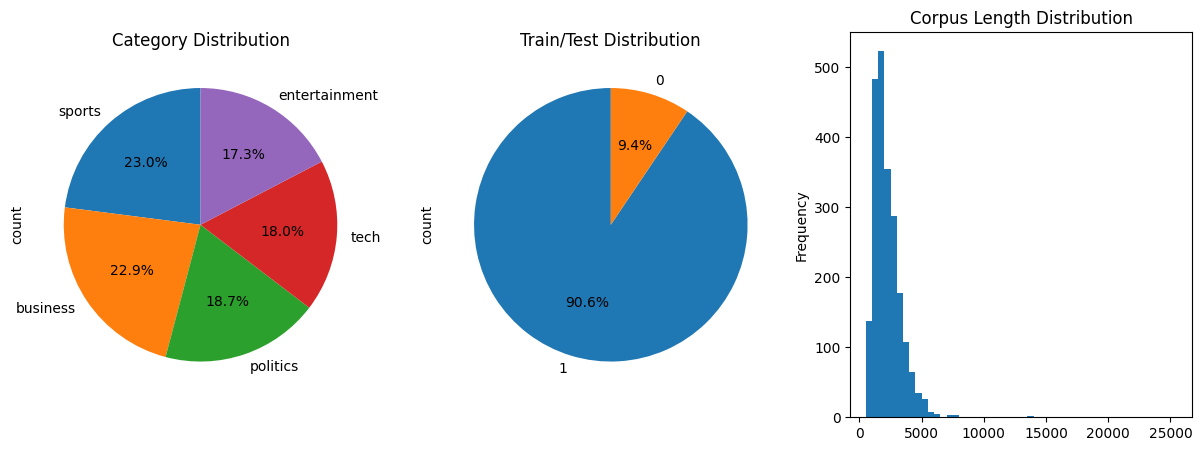

In [8]:
# plot category distribution as pie chart of columns category, train and len(corpus)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
df['category'].value_counts().plot.pie(ax=ax[0], autopct='%1.1f%%', startangle=90, title='Category Distribution')
df['train'].value_counts().plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, title='Train/Test Distribution')
df['len'] = df['corpus'].apply(len)
df['len'].plot.hist(ax=ax[2], bins=50, title='Corpus Length Distribution')
plt.show()

Ahora realizamos el mismo proceso pero separando en los conjuntos train y test, para ver si la distribución varía entre estas.

C:\Users\NoobG\AppData\Local\Temp\ipykernel_26556\3329944406.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['train']==1]['len'] = df['corpus'].apply(len)


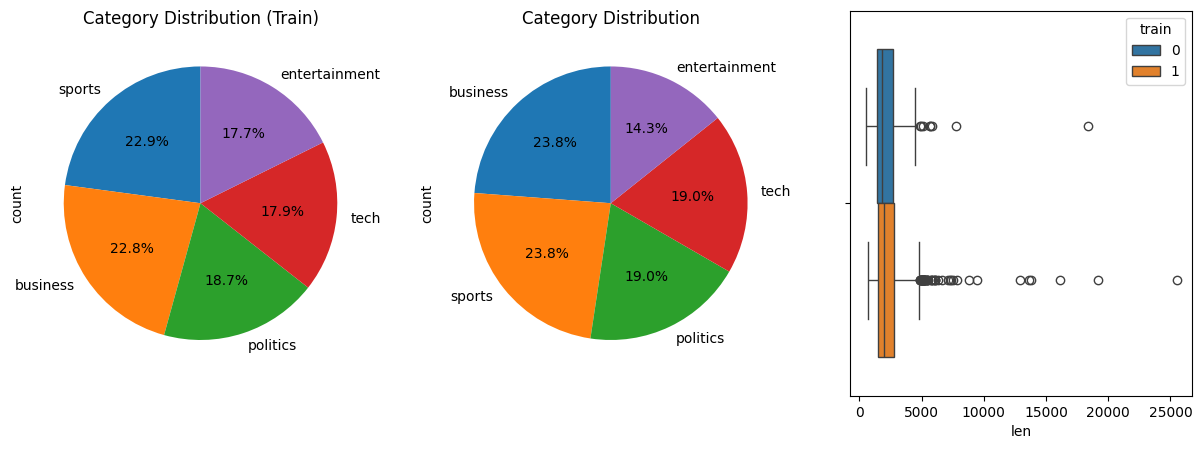

In [9]:
# plot category distribution as pie chart of columns category, train and len(corpus) but filtering by the train column
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
df[df['train']==1]['category'].value_counts().plot.pie(ax=ax[0], autopct='%1.1f%%', startangle=90, title='Category Distribution (Train)')
df[df['train']==0]['category'].value_counts().plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, title='Category Distribution')
df[df['train']==1]['len'] = df['corpus'].apply(len)
# df[df['train']==1]['len'].plot.hist(ax=ax[2], bins=50, title='Corpus Length Distribution', hue='Train')
sns.boxplot(data=df, x='len', hue='train')
plt.show()

Se observa que las distribuciones se mantienen más o menos constante, en tanto las categorías como las longitudes de corpus de manera general.

Ahora comprobaremos las longitudes de las diferentes categorías

<Axes: xlabel='len', ylabel='category'>

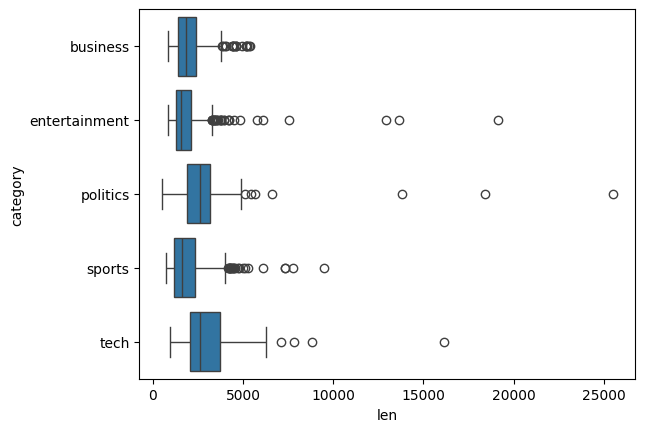

In [10]:
sns.boxplot(data=df, x='len', y='category')

Se observa que a pesar de que a pesar de que en grandes rasgos tienen un rango similar, si nos fijamos detalladamente, se puede observarq ue si que hay una diferencia más notable. Esto se observa precisamente en caso de tech que tiene en media y en rango IQR, mayor longitud que los de deporte, entretenimiento y business.

### Conclusión (EDA)

Hemos visto en el apartado de EDA que no hay desbalance significativo aparte de la diferencia en la longitud de las oraciones.

Nota: Las longitudes son de corpus absoluto, lo cual incluye espacios, "\n" entre otros caracteres especiales. Pero esto nos sirve para tener un conocimiento aproximado.

## Preprocessing

### Libraries

In [11]:
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### Cleaning

Utilizamos la libreria de spacy para limpiar el texto y obtener los tokens.

Esta función lo que hace es mediante el uso de la libreria spacy, filtramos los tokens (palabras o elementos) que sean stop words, signos de puntuación (signos monetarios) y espacios.

Mantenemos los casos los signos monetarios porque podría dar más información del contexto del topic.

Hacemos lematización en vez de stematización para mantener el mayor contexto posible.

In [12]:
nlp = spacy.load("en_core_web_sm")  # Usa 'en_core_web_md' o 'en_core_web_lg' para modelos más grandes

def tokenizer(text):
    """
    Limpia un texto
    """
    doc = nlp(text)

    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]

    return tokens

In [13]:
def token_to_corpus(token_list):
    """
    Convierte una lista de tokens en un texto
    """
    return " ".join(token_list)

In [14]:
df['tokens'] = df['corpus'].progress_apply(tokenizer)

 41%|████▏     | 922/2225 [00:26<00:37, 35.19it/s]


KeyboardInterrupt: 

In [ ]:
df['corpus'] = df['tokens'].progress_apply(token_to_corpus)

100%|██████████| 2225/2225 [00:00<00:00, 261548.90it/s]


In [ ]:
df['corpus'][0]

'trade gap hit record 2004 gap export import hit time high $ 671.7bn £ 484bn 2004 late figure commerce department say trade deficit year 24.4 previous record 2003 imbalance $ 496.5bn deficit china 30.5 $ 162bn large record single country monthly basis trade gap narrow 4.9 december £ 56.4bn consumer appetite thing oil import car wine cheese reach record level year figure likely spark fresh criticism president bush economic policy democrats claim administration clamp unfair foreign trade practice example believe china currency policy manufacturer claim undervalue yuan 40 give china rapidly expand economy unfair advantage competitor bush administration argue deficit reflect fact america grow fast rate rest world spur demand import good economist allow upward revision economic growth fourth quarter point deficit reach astronomical proportion foreigner choose hold dollar denominate asset turn harm growth 2004 export rise 12.3 $ 1.15 trillion import rise fast 16.3 new record $ 1.76 trillion 

In [ ]:
df['tokens'][0]

['trade',
 'gap',
 'hit',
 'record',
 '2004',
 'gap',
 'export',
 'import',
 'hit',
 'time',
 'high',
 '$',
 '671.7bn',
 '£',
 '484bn',
 '2004',
 'late',
 'figure',
 'commerce',
 'department',
 'say',
 'trade',
 'deficit',
 'year',
 '24.4',
 'previous',
 'record',
 '2003',
 'imbalance',
 '$',
 '496.5bn',
 'deficit',
 'china',
 '30.5',
 '$',
 '162bn',
 'large',
 'record',
 'single',
 'country',
 'monthly',
 'basis',
 'trade',
 'gap',
 'narrow',
 '4.9',
 'december',
 '£',
 '56.4bn',
 'consumer',
 'appetite',
 'thing',
 'oil',
 'import',
 'car',
 'wine',
 'cheese',
 'reach',
 'record',
 'level',
 'year',
 'figure',
 'likely',
 'spark',
 'fresh',
 'criticism',
 'president',
 'bush',
 'economic',
 'policy',
 'democrats',
 'claim',
 'administration',
 'clamp',
 'unfair',
 'foreign',
 'trade',
 'practice',
 'example',
 'believe',
 'china',
 'currency',
 'policy',
 'manufacturer',
 'claim',
 'undervalue',
 'yuan',
 '40',
 'give',
 'china',
 'rapidly',
 'expand',
 'economy',
 'unfair',
 'advant

Decidimos mantener los simbolos especiales como $ porque creemos que puede tener impacto entre diferentes topics


### Analisis con Word Cloud

Ahora que tenemos los elementos tokenizados, vamos a hacer un análisis con word cloud para ver la frecuencia y relevancia de las palabras en el corpus con todas las categorías.

Hacemos wordcloud de unigramas porque wordclouds de ngramas mayores (superconjunto de unigramas) tendrán menores frecuencias en comparación con los unigramas y por ende menos "representativo".

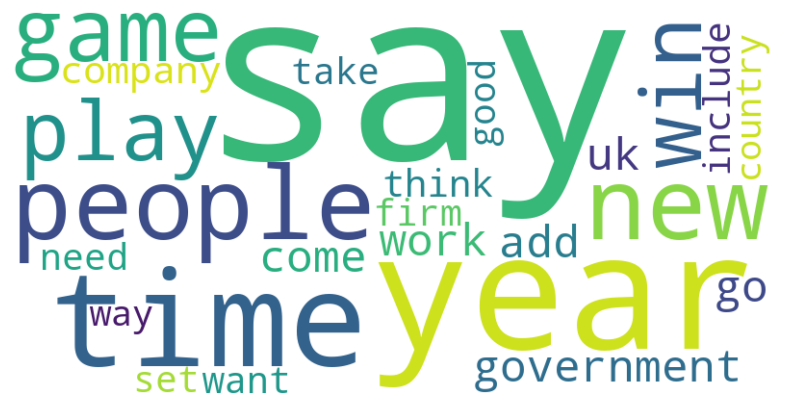

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# all_tokens es la lista aplanada de todos los tokens (ya limpios)

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=25)
wordcloud.generate(" ".join(df['tokens'].sum()))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Ahora realizamos un estudio de las palabras mas comunes por categoría, en la cual podemos observar que hay palabras (verbos) que se aparecen con una alta fracuencia en todas, como "say". Sin embargo, se ve que en general las palabras con mayor frecuencia de las diferentes categorías tienden a ser bastante diferenciables.

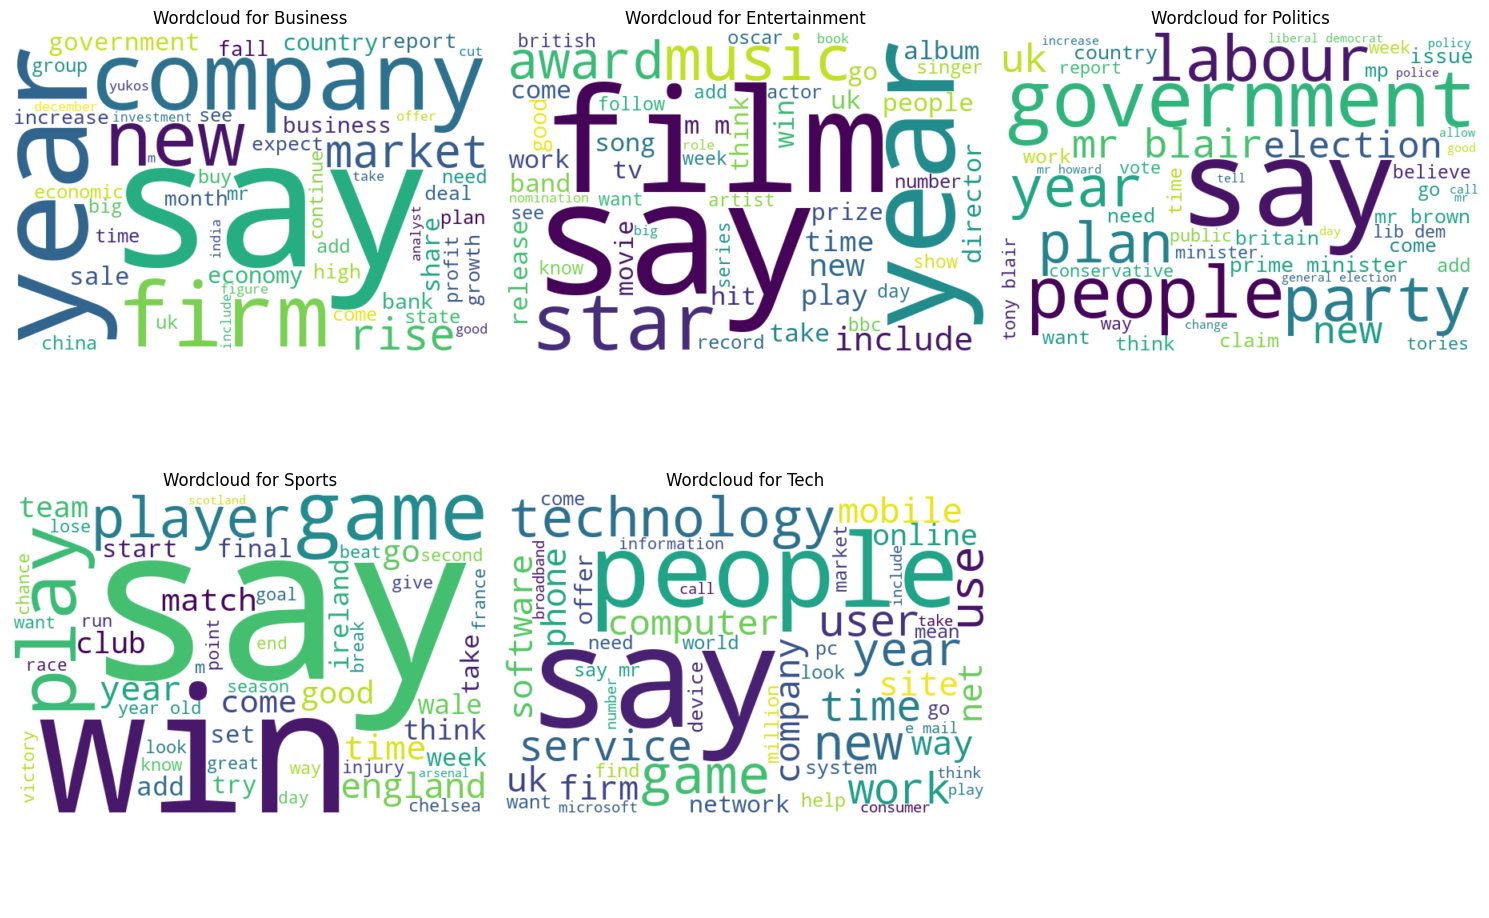

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust figsize as needed.
axes = axes.flatten()


# all_tokens es la lista aplanada de todos los tokens (ya limpios)
for i, category in enumerate(df['category'].unique()):
    wordcloud = WordCloud(width=600, height=400, background_color='white', max_words=50)
    wordcloud_df = df[df['category'] == 'business']
    
    wordcloud.generate(" ".join(df[df['category'] == category]['tokens'].sum()))

    ax = axes[i]  # Get the *current* subplot.
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Wordcloud for {category.capitalize()}')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Vectorización

#### Word embeddings

1. Transformer-Based Embeddings (Generally the Best Overall):


BERT (and its variants): BERT (Bidirectional Encoder Representations from Transformers) and its many variants (RoBERTa, DistilBERT, ALBERT) are currently the gold standard for many NLP tasks.
Strengths: Contextualized embeddings mean word representations change based on their surroundings. Excellent for tasks like sentiment analysis, question answering, and text classification.
Weaknesses: Can be computationally expensive to train and use (especially large models). Requires a good understanding of transformer architectures.

---
Usamos BERT base uncased por tener un modelo pequeño para ver su rendimiento y uncased porque ya pasamos a lower los tokens.

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

In [ ]:
modelo_nombre="bert-base-uncased"
device="cpu"

tokenizer = BertTokenizer.from_pretrained(modelo_nombre)
model = BertModel.from_pretrained(modelo_nombre).to(device)

def obtener_embedding_bert(corpus):
    encoded_input = tokenizer(corpus, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():  # Desactivar cálculo de gradientes para inferencia
        outputs = model(**encoded_input)
    embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embedding

Con un i14700kf tarda 2:30 en ejecutar.

In [ ]:
df['embedding'] = df['corpus'].progress_apply(lambda x: obtener_embedding_bert(x))

100%|██████████| 2225/2225 [02:30<00:00, 14.79it/s]


Una vez que tenemos los embeddings lo utilizaremos como input para el modelo.
Utilizaremos SVMs debido a lo bien que se ajusta para espacios de alta dimensionalidad.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
df.head(3)

,id,category,train,corpus,len,tokens,embedding
0,024.txt,business,0,trade gap hit record 2004 gap export import hi...,1952,"[trade, gap, hit, record, 2004, gap, export, i...","[[-0.48371905, 0.10633793, 0.43034765, 0.17049..."
1,025.txt,business,0,yukos lose bankruptcy battle judge dismiss att...,2703,"[yukos, lose, bankruptcy, battle, judge, dismi...","[[-0.47682828, 0.08658477, 0.17508967, -0.2217..."
2,026.txt,business,0,safety alert gm recall car world big carmaker ...,1829,"[safety, alert, gm, recall, car, world, big, c...","[[-0.72342736, 0.35176423, 0.015273539, -0.081..."


In [ ]:
def prepare_embeddings(embeddings_series):
    embeddings_list = []
    for emb in embeddings_series:
        emb_array = np.array(emb)
        # Si es un array 2D (por ejemplo [1, 768]), aplanarlo
        if len(emb_array.shape) > 1:
            emb_array = emb_array.flatten()
        embeddings_list.append(emb_array)
    return np.array(embeddings_list)

In [ ]:
X_train = prepare_embeddings(df[df['train'] == 1]['embedding'])
X_test = prepare_embeddings(df[df['train'] == 0]['embedding'])

y_train = df[df['train'] == 1]['category']
y_test = df[df['train'] == 0]['category']

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Número de muestras de entrenamiento: {len(y_train)}")
print(f"Número de muestras de prueba: {len(y_test)}")

X_train shape: (2015, 768)
X_test shape: (210, 768)
Número de muestras de entrenamiento: 2015
Número de muestras de prueba: 210


In [ ]:
categories = df['category'].unique()
print(f"Categorías disponibles: {categories}")
print(f"Número de categorías: {len(categories)}")


Categorías disponibles: ['business' 'entertainment' 'politics' 'sports' 'tech']
Número de categorías: 5


In [ ]:
model = LinearSVC(C=1.0, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

               precision    recall  f1-score   support

     business       1.00      1.00      1.00        50
entertainment       0.97      1.00      0.98        30
     politics       1.00      1.00      1.00        40
       sports       1.00      1.00      1.00        50
         tech       1.00      0.97      0.99        40

     accuracy                           1.00       210
    macro avg       0.99      0.99      0.99       210
 weighted avg       1.00      1.00      1.00       210

Matriz de confusión:
[[50  0  0  0  0]
 [ 0 30  0  0  0]
 [ 0  0 40  0  0]
 [ 0  0  0 50  0]
 [ 0  1  0  0 39]]


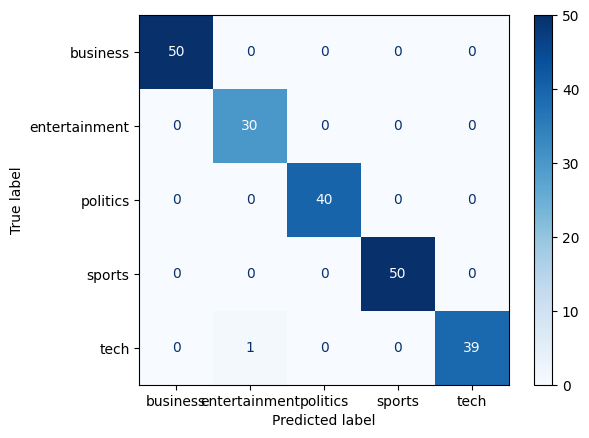

In [ ]:
print(classification_report(y_test, y_pred))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Generar la matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
print("Matriz de confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=model.classes_)
disp.plot(cmap="Blues")

In [ ]:
incorrect_indices = np.where(y_pred != y_test)[0]
print(f"Total de clasificaciones incorrectas: {len(incorrect_indices)} de {len(y_test)}")

df_test_indices = df[df['train'] == 0].index
incorrect_samples = df.loc[df_test_indices[incorrect_indices]]

for i, (idx, row) in enumerate(incorrect_samples.iterrows()):
    if i >= 10: break  
    print(f"\nÍndice original: {idx}")
    print(f"Texto: {row['corpus']}") 
    print(f"Categoría real: {row['category']}")
    print(f"Categoría predicha: {y_pred[incorrect_indices[i]]}")


Total de clasificaciones incorrectas: 1 de 210

Índice original: 173
Texto: uk pioneer digital film network world digital cinema network establish uk 18 month uk film council award contract worth £ 11.5 m arts alliance digital cinema aadc set network 250 screen aadc oversee selection cinema uk use digital equipment high definition projector computer server instal mainly british specialist film cinema currently mechanical projector new network 250 screen 150 cinema fit digital projector capable display high definition image new network double world total digital screen cinemas give film portable hard drive copy content computer server film 100 gigabyte compress original terabyte size file fiona deans associate director aadc say compression visually lossless picture degradation occur film encrypt prevent piracy cinema individual key unlock movie people picture quality bit clear scratch picture look exactly print degradation quality time key benefit digital network increase distribution s

Se ve que el elemento misclasificado es entendible porque trata sobre aspectos tecnológicos del cine digital.

Una vez que hemos hecho una prueba base, con un rendimiento bastante bueno, procedemos a ver si se podría mejorar más con optimización de hiperarámetros.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.svm import SVC

Tarda 40 s con i14700kf

In [ ]:
f1_scorer = make_scorer(f1_score, average='weighted')

param_grid = {
    'C': [0.5, 1, 1.5, 2],
    'tol': [1e-3, 1e-4, 1e-5],
    'dual': [True, False],
    'max_iter': [1000, 2000, 3000]
}

svc = LinearSVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)

# Usar el mejor modelo
best_svm = grid_search.best_estimator_


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejor valor de C: 1.5
Mejor puntuación: 0.9764


               precision    recall  f1-score   support

     business       0.96      0.97      0.97       102
entertainment       0.97      1.00      0.99        77
     politics       0.98      0.98      0.98        84
       sports       0.99      0.99      0.99       102
         tech       0.99      0.95      0.97        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445

Matriz de confusión:
[[ 99   0   1   1   1]
 [  0  77   0   0   0]
 [  1   1  82   0   0]
 [  1   0   0 101   0]
 [  2   1   1   0  76]]


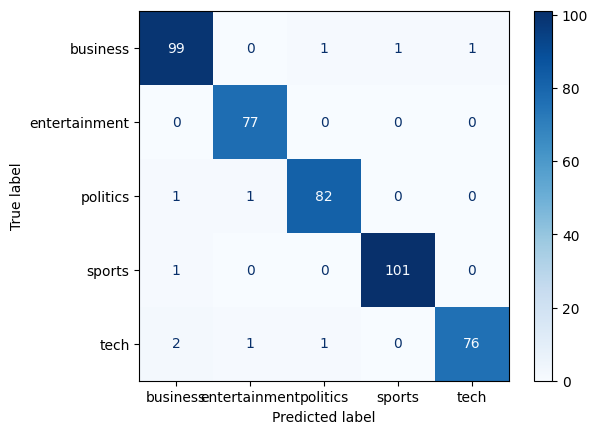

In [ ]:
y_pred = best_svm.predict(X_test)

print(classification_report(y_test, y_pred))

# Generar la matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
print("Matriz de confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=model.classes_)
disp.plot(cmap="Blues")


Se ha intentado optimizar el modelo intentando acertar el último elemnto sin mucho éxito. Por lo que nos quedamos con el modelo base.

---

### Modelado

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X = prepare_embeddings(df['embedding'].values)
print(f"Matriz de embeddings: {X.shape}")  # (n_muestras, dimensiones_embedding)

Matriz de embeddings: (2225, 768)


Usamos tfidf porque para lda y nmf viene mejor la tasa de frecuencias.
Nos permite identificar terminos distintivos del corpus y es mas directo e interpretable para los temas.
Elegimos LDA y NMF porque como con tfidf, permite una mayor interplretabilidad que otros modelos como Kmedias basadas en embedding, aunque estos últimos pueden capturar mejor la semántica capturada por los embeddings.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(analyzer=lambda x: x, token_pattern=None)
bow = vectorizer.fit_transform(df['tokens'])

tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x: x, token_pattern=None)
tfidf = tfidf_vectorizer.fit_transform(df['tokens'])

In [ ]:
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import davies_bouldin_score
import numpy as np

dictionary = Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

# Para guardar métricas
coherence_cv_values = []
coherence_npmi_values = []
dbi_values = []

# Evaluar modelos con diferente número de tópicos
for num_topics in tqdm(range(2, 8), desc="Evaluando tópicos"):
    # LDA con sklearn
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_output = lda.fit_transform(bow)

    # Davies-Bouldin Index
    dbi_values.append(davies_bouldin_score(lda_output, lda_output.argmax(axis=1)))
    
    # LDA con gensim para coherencia
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    coherence_cv = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_npmi = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_npmi')
    
    coherence_cv_values.append(coherence_cv.get_coherence())
    coherence_npmi_values.append(coherence_npmi.get_coherence())



NameError: name 'df' is not defined

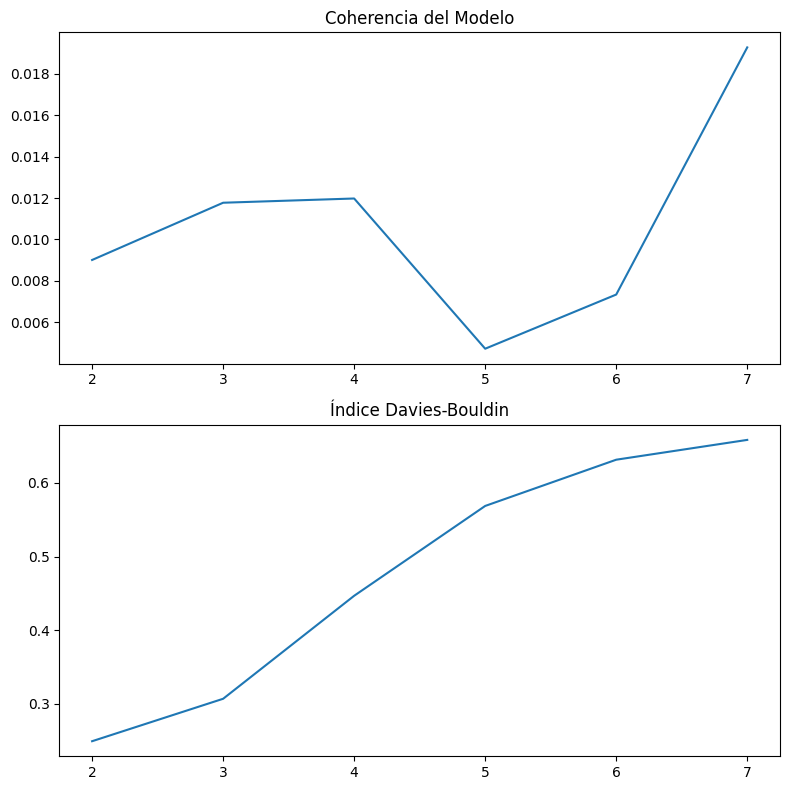

In [ ]:
import matplotlib.pyplot as plt

# Graficar métricas
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
x = list(range(2, 8))

axs[0].plot(x, coherence_values)
axs[0].set_title('Coherencia del Modelo')

axs[1].plot(x, dbi_values)
axs[1].set_title('Índice Davies-Bouldin')

plt.tight_layout()
plt.show()

# Determinar número óptimo de tópicos
# Para coherencia: mayor valor es mejor
# Para perplejidad: menor valor es mejor
# Para DBI: menor valor es mejor

In [ ]:
optimal_topics = 5

# Modelo LDA final
lda_model = LatentDirichletAllocation(n_components=optimal_topics, random_state=42)
lda_output = lda_model.fit_transform(bow)

# Modelo NMF final
nmf_model = NMF(n_components=optimal_topics, random_state=42)
nmf_output = nmf_model.fit_transform(tfidf)

In [ ]:
# Mostrar las palabras principales en cada tópico del LDA
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in range(1, enumerate(lda_model.components_)+1):
    top_words_idx = topic.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Tópico {topic_idx}: {' '.join(top_words)}")
    
# Similar para NMF
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-11:-1]
    top_words = [tfidf_feature_names[i] for i in top_words_idx]
    print(f"Tópico NMF {topic_idx}: {' '.join(top_words)}")

TypeError: unsupported operand type(s) for +: 'enumerate' and 'int'

---

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
ngram_range = (1, 2)

# Bag of Words con n-gramas
bow_vectorizer = CountVectorizer(ngram_range=ngram_range)
X_bow = bow_vectorizer.fit_transform(df['corpus'])

# TF-IDF con n-gramas
tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range)
X_tfidf = tfidf_vectorizer.fit_transform(df['corpus'])


Modelado de Temas con LDA (BoW)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

TODO: Por que se ha elegido ncomponents
Probar diferentes ngramas con diferentes metricas: coherence score y Davies Boulding Index, Perplexity

In [ ]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X_bow)

feature_names = bow_vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]
    print(f"🔹 Topic {idx + 1}: {', '.join(top_words)}")

🔹 Topic 1: government, firm, mobile, party, uk, new, people, year, mr, say
🔹 Topic 2: win, new, government, time, company, good, people, mr, year, say
🔹 Topic 3: play, people, time, film, win, new, good, year, mr, say
🔹 Topic 4: mr, play, player, win, people, time, new, game, year, say
🔹 Topic 5: new, good, people, game, time, play, win, mr, year, say


Modelado de Temas con NMF (TF-IDF)

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
nmf_model = NMF(n_components=5, random_state=42)
nmf_model.fit(X_tfidf)

feature_names = tfidf_vectorizer.get_feature_names_out()
for idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]
    print(f"🔹 Topic {idx + 1}: {', '.join(top_words)}")

🔹 Topic 1: software, digital, user, service, say, music, technology, people, phone, mobile
🔹 Topic 2: minister, mr brown, mr blair, brown, say, party, blair, election, labour, mr
🔹 Topic 3: cup, ireland, team, match, say, player, play, england, win, game
🔹 Topic 4: director, festival, actress, win, oscar, actor, star, good, award, film
🔹 Topic 5: sale, market, year, price, bank, rate, rise, economy, say, growth


Clasificación con TF-IDF + Regresión Logística

##